In [70]:
import networkx as nx
import dill as pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import scipy.optimize as opt
import copy
from mpl_toolkits.basemap import Basemap
import collections
import pandas as pd
# Supress warnings
import warnings
warnings.filterwarnings("ignore")

In [71]:
# Read pickled graphs graph_objects/G_multi_directed.pickle, graph_objects/G_multi_undirected.pickle, graph_objects/G_simple_directed.pickle, graph_objects/G_simple_undirected.pickle
with open('graph_objects/G_multi_directed_iggielgn.pickle', 'rb') as f:
    G_multi_directed = pickle.load(f)

with open('graph_objects/G_multi_undirected_iggielgn.pickle', 'rb') as f:
    G_multi_undirected = pickle.load(f)

with open('graph_objects/G_simple_directed_iggielgn.pickle', 'rb') as f:
    G_simple_directed = pickle.load(f)

with open('graph_objects/G_simple_undirected_iggielgn.pickle', 'rb') as f:
    G_simple_undirected = pickle.load(f)

In [72]:
# Print the number of edges in each graph
print("Number of edges in G_multi_directed:")
print(nx.number_of_edges(G_multi_directed))
print("Number of edges in G_multi_undirected:")
print(nx.number_of_edges(G_multi_undirected))
print("Number of edges in G_simple_directed:")
print(nx.number_of_edges(G_simple_directed))
print("Number of edges in G_simple_undirected:")
print(nx.number_of_edges(G_simple_undirected))

Number of edges in G_multi_directed:
6528
Number of edges in G_multi_undirected:
6160
Number of edges in G_simple_directed:
6012
Number of edges in G_simple_undirected:
5673


In [73]:
# For the nodes, print a value count of the country_code attribute
print("Value count of country_code in G_multi_directed:")
print(pd.Series(nx.get_node_attributes(G_multi_directed, 'country_code')).value_counts())
# Print the number of unique values
print("Number of unique values in G_multi_directed:")
print(len(pd.Series(nx.get_node_attributes(G_multi_directed, 'country_code')).value_counts()))

Value count of country_code in G_multi_directed:
DE    635
FR    622
RU    390
IT    374
GB    224
ES    211
UA    206
PL    198
TR    180
RO    167
DZ    161
NL    120
HU     99
BY     87
NO     81
BG     75
EG     74
BE     70
IE     54
AT     51
RS     42
CZ     41
FI     40
GE     39
HR     36
LT     35
GR     33
PT     29
CH     28
DK     27
EE     24
SI     23
KZ     22
LV     20
TN     20
MD     19
SE     18
SK     18
AZ     13
SY     10
AM      9
IQ      7
LY      6
IL      6
JO      6
LU      5
MK      4
IR      4
PS      3
AL      2
BA      2
EL      2
TM      1
LB      1
MT      1
Name: count, dtype: int64
Number of unique values in G_multi_directed:
55


In [74]:
# Print the ids of the nodes that have self-loops in each graph
print("Nodes with self-loops in G_multi_directed:")
temp = [element.split("_")[0] for element in nx.nodes_with_selfloops(G_multi_directed)]
# Take value count of temp
print(collections.Counter(temp))

Nodes with self-loops in G_multi_directed:
Counter({'SEQ': 66, 'LKD': 25, 'N': 12, 'INET': 3, 'NO': 1})


In [75]:
# Print the number of self-loops in each graph
print("Number of self-loops in G_multi_directed:")
print(nx.number_of_selfloops(G_multi_directed))
print("Number of self-loops in G_multi_undirected:")
print(nx.number_of_selfloops(G_multi_undirected))
print("Number of self-loops in G_simple_directed:")
print(nx.number_of_selfloops(G_simple_directed))
print("Number of self-loops in G_simple_undirected:")
print(nx.number_of_selfloops(G_simple_undirected))

Number of self-loops in G_multi_directed:
128
Number of self-loops in G_multi_undirected:
128
Number of self-loops in G_simple_directed:
107
Number of self-loops in G_simple_undirected:
107


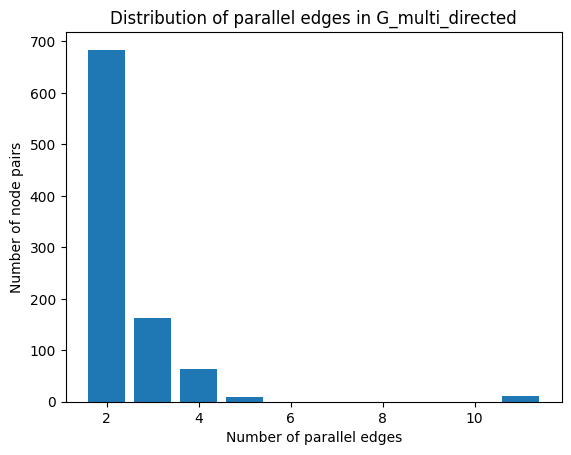

Number of parallel edges in G_multi_directed:
Number of node pairs with 2 parallel edges: 342.0
Number of node pairs with 3 parallel edges: 54.0
Number of node pairs with 4 parallel edges: 16.0
Number of node pairs with 5 parallel edges: 2.0
Number of node pairs with 11 parallel edges: 1.0


In [76]:
# Plot the distribution plot of parallel edges in G_multi_directed, i.e., the number of node pairs with 1, 2, 3, ... parallel edges
parallel_edges_dict = {}
for u, v, d in G_multi_directed.edges:
    # Check if the edge has more than one edge between the same nodes
    if len(G_multi_directed[u][v]) > 1:
        if len(G_multi_directed[u][v]) in parallel_edges_dict:
            parallel_edges_dict[len(G_multi_directed[u][v])] += 1
        else:
            parallel_edges_dict[len(G_multi_directed[u][v])] = 1
parallel_edges_dict = collections.OrderedDict(sorted(parallel_edges_dict.items()))
plt.figure()
plt.bar(parallel_edges_dict.keys(), parallel_edges_dict.values())
plt.xlabel('Number of parallel edges')
plt.ylabel('Number of node pairs')
plt.title('Distribution of parallel edges in G_multi_directed')
plt.show()

In [78]:
# Create a dictionary. The keys are the country_codes and the values are 1) the number of nodes in the country 2) the number of to_edges in the country 3) the number of from_edges in the country 4) the number of total edges in the country

country_dict = {}
for node in G_simple_directed.nodes:
    country_code = G_simple_directed.nodes[node]['country_code']
    if country_code in country_dict:
        country_dict[country_code][0] += 1
    else:
        country_dict[country_code] = [1, 0, 0]

for edge in G_simple_directed.edges(data=True):
    from_country_code = edge[2]['from_country_code']
    to_country_code = edge[2]['to_country_code']
    if from_country_code in country_dict:
        country_dict[from_country_code][1] += 1
    else:
        country_dict[from_country_code] = [0, 1, 0]
    if to_country_code in country_dict:
        country_dict[to_country_code][2] += 1

In [79]:
countries_df = pd.DataFrame.from_dict(country_dict, orient='index', columns=['number_of_nodes', 'number_of_to_edges', 'number_of_from_edges'])
countries_list = countries_df.index.tolist()

,number_of_nodes,number_of_to_edges,number_of_from_edges
PL,198,271,273
IT,374,487,487
AT,51,82,85
AL,2,2,2
SK,18,23,20


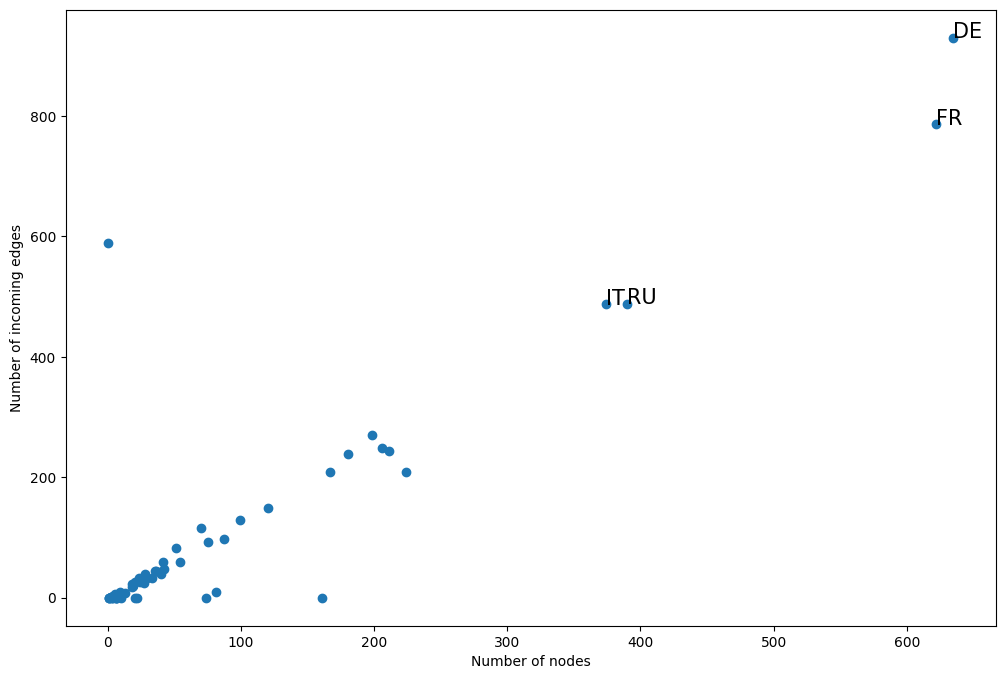

In [80]:
# Using the number_nodes as the x-axis and the number_of_to_edges as the y-axis, plot the number of to_edges vs the number of nodes
plt.figure(figsize=(12, 8))
plt.scatter(countries_df['number_of_nodes'], countries_df['number_of_to_edges'])
plt.xlabel('Number of nodes')
plt.ylabel('Number of incoming edges')
for i, txt in enumerate(countries_df.index):
    if countries_df['number_of_nodes'][i] > 300:
        plt.annotate(txt, (countries_df['number_of_nodes'][i], countries_df['number_of_to_edges'][i]), fontsize=15)

plt.savefig('latex_figures/number_of_nodes_vs_number_of_to_edges.png')
plt.show()

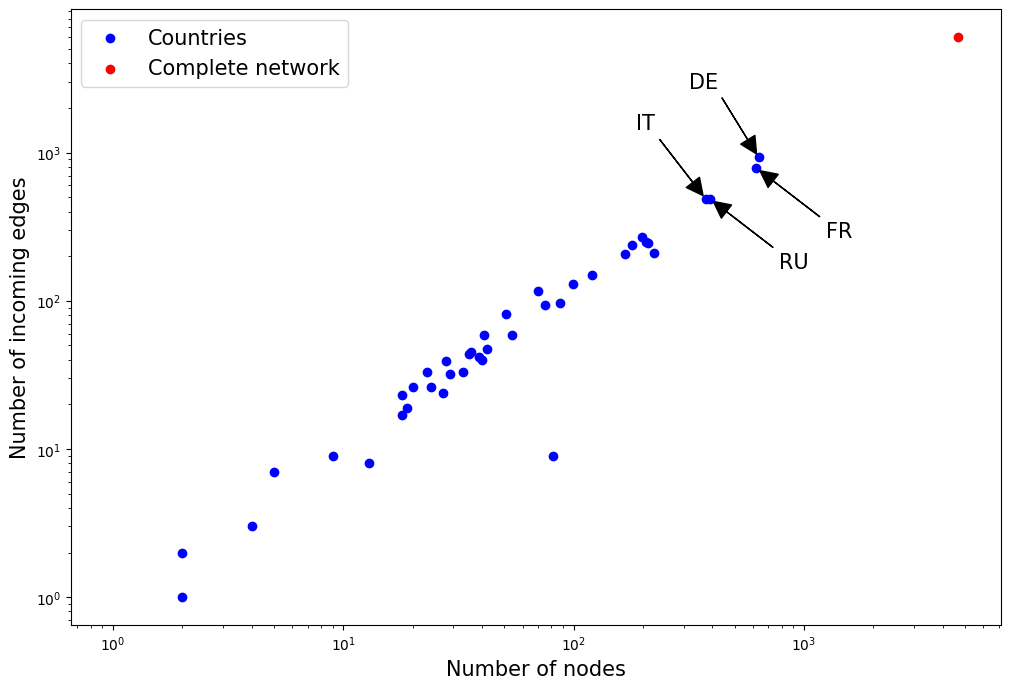

In [81]:
# Using the number_nodes as the x-axis and the number_of_to_edges as the y-axis, plot the number of to_edges vs the number of nodes
plt.figure(figsize=(12, 8))
plt.scatter(countries_df['number_of_nodes'], countries_df['number_of_to_edges'], c='blue')
plt.scatter(nx.number_of_nodes(G_simple_directed), nx.number_of_edges(G_simple_directed), c='red')
plt.xlabel('Number of nodes', fontsize=15)
plt.ylabel('Number of incoming edges', fontsize=15)
# Add a label and an arrow to the point for the countries DE, FR, IT, and RU
for i, txt in enumerate(countries_df.index):
    if countries_df.index[i] in ['DE', 'IT']:
        plt.annotate(txt, (countries_df['number_of_nodes'][i], countries_df['number_of_to_edges'][i]), fontsize=15, arrowprops=dict(facecolor='black', shrink=0.05, width=0.05), xytext=(-50, 50,), textcoords='offset points')
    if countries_df.index[i] in ['FR', 'RU']:
        plt.annotate(txt, (countries_df['number_of_nodes'][i], countries_df['number_of_to_edges'][i]), fontsize=15, arrowprops=dict(facecolor='black', shrink=0.05, width=0.05), xytext=(50, -50,), textcoords='offset points')
plt.xscale('log')
plt.yscale('log')
plt.legend(['Countries', 'Complete network'], loc='upper left', fontsize=15)
plt.savefig('latex_figures/number_of_nodes_vs_number_of_to_edges_plus_entire_graph.png')
plt.show()

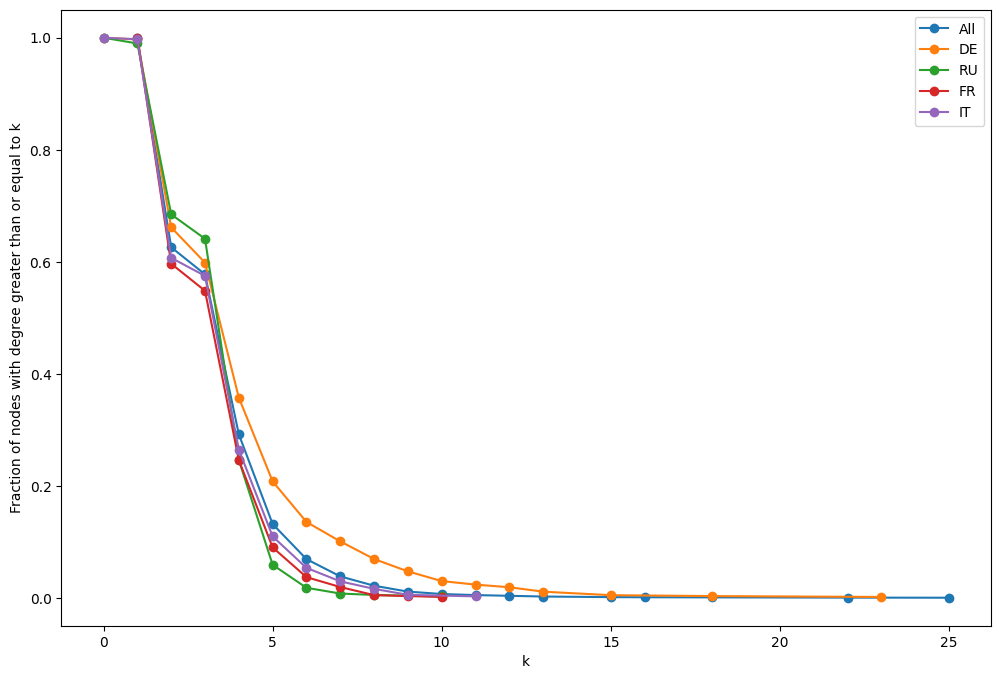

In [82]:
# Do the same as above, but do five different series, one for the entire graph, one for nodes where country_code is DE, RU, FR, and IT
plt.figure(figsize=(12, 8))
# Keep in min I want to plot the fraction of nodes with degree greater than or equal to k vs k
# One would expect the curve to begin at 1 and decrease to 0
degree_sequence = sorted([d for n, d in G_multi_directed.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
cumulative_cnt = np.cumsum(cnt)
cumulative_cnt = cumulative_cnt / cumulative_cnt[-1]
plt.plot(deg, cumulative_cnt, 'o-', label='All')

for country_code in ['DE', 'RU', 'FR', 'IT']:
    # Create a subgraph of G_multi_directed where the country_code is the one we are interested in
    sub_graph = G_multi_directed.subgraph([n for n in G_multi_directed.nodes if G_multi_directed.nodes[n]['country_code'] == country_code])
    degree_sequence = sorted([d for n, d in sub_graph.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    cumulative_cnt = np.cumsum(cnt)
    cumulative_cnt = cumulative_cnt / cumulative_cnt[-1]
    plt.plot(deg, cumulative_cnt, 'o-', label=country_code)

plt.xlabel('k')
plt.ylabel('Fraction of nodes with degree greater than or equal to k')
plt.legend()

plt.savefig('latex_figures/degree_distribution_selected.png')
plt.show()

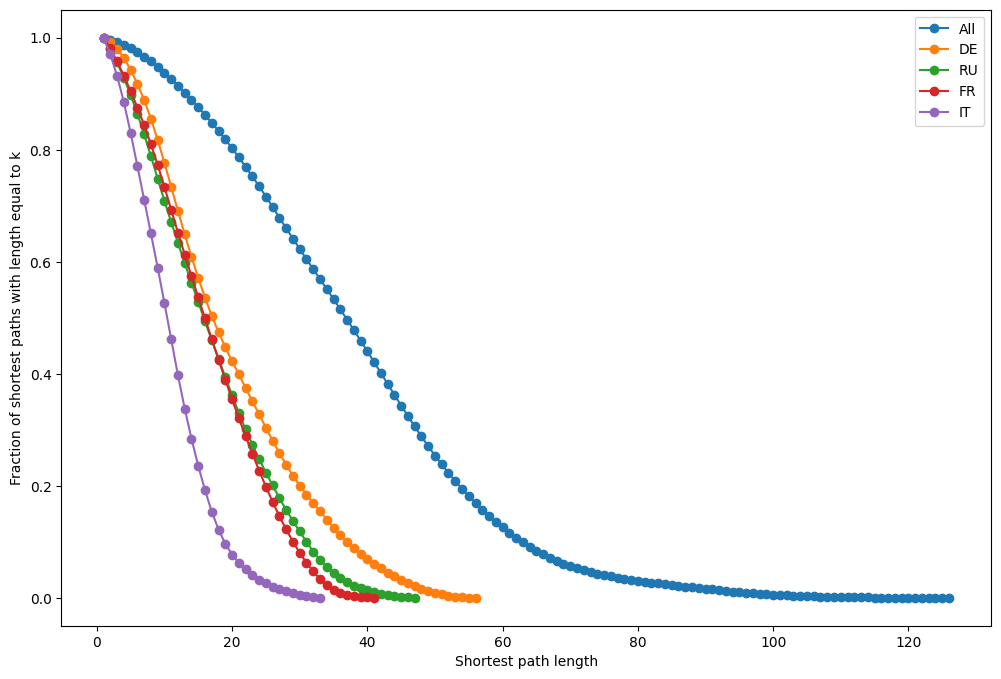

In [83]:
# Do the same as above, only do the shortest path length distribution
plt.figure(figsize=(12, 8))
shortest_path_lengths = nx.shortest_path_length(G_multi_directed)
shortest_path_lengths = [length for node, lengths in shortest_path_lengths for length in lengths.values()]
shortest_path_lengths = [length for length in shortest_path_lengths if length != 0]
shortest_path_lengths = sorted(shortest_path_lengths, reverse=True)
shortest_path_lengths_count = collections.Counter(shortest_path_lengths)
spl, cnt = zip(*shortest_path_lengths_count.items())
cumulative_cnt = np.cumsum(cnt)
cumulative_cnt = cumulative_cnt / cumulative_cnt[-1]
plt.plot(spl, cumulative_cnt, 'o-', label='All')

for country_code in ['DE', 'RU', 'FR', 'IT']:
    # Create a subgraph of G_multi_directed where the country_code is the one we are interested in
    sub_graph = G_multi_directed.subgraph([n for n in G_multi_directed.nodes if G_multi_directed.nodes[n]['country_code'] == country_code])
    shortest_path_lengths = nx.shortest_path_length(sub_graph)
    shortest_path_lengths = [length for node, lengths in shortest_path_lengths for length in lengths.values()]
    shortest_path_lengths = [length for length in shortest_path_lengths if length != 0]
    shortest_path_lengths = sorted(shortest_path_lengths, reverse=True)
    shortest_path_lengths_count = collections.Counter(shortest_path_lengths)
    spl, cnt = zip(*shortest_path_lengths_count.items())
    cumulative_cnt = np.cumsum(cnt)
    cumulative_cnt = cumulative_cnt / cumulative_cnt[-1]
    plt.plot(spl, cumulative_cnt, 'o-', label=country_code)
    
plt.xlabel('Shortest path length')
plt.ylabel('Fraction of shortest paths with length equal to k')
plt.legend()

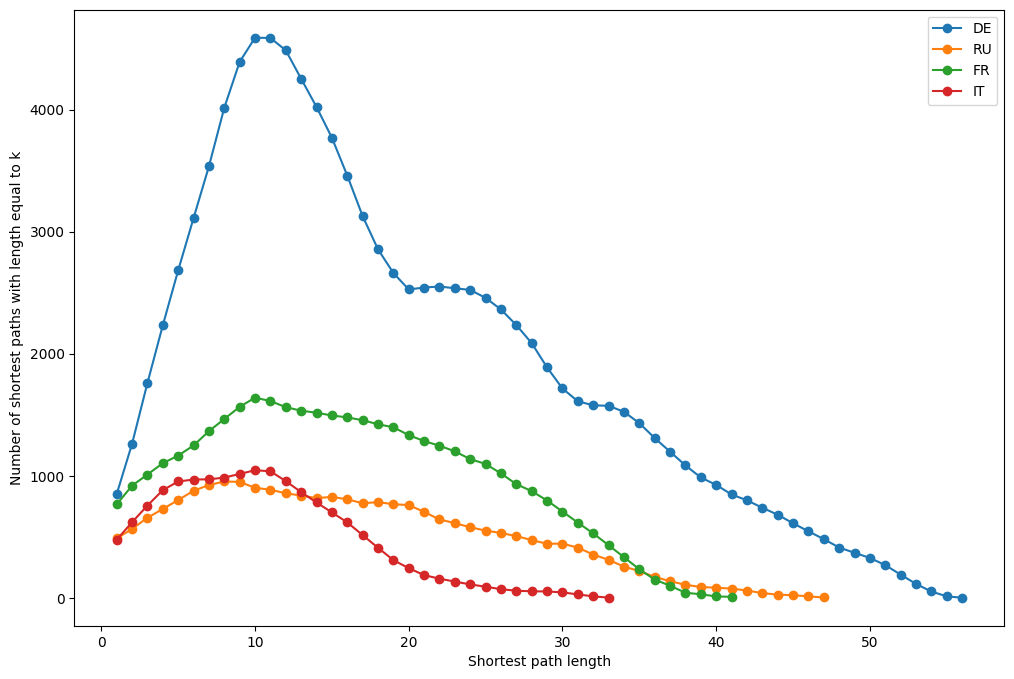

In [84]:
# Plot the normal shortest path length distribution (i.e., not cumulative)
plt.figure(figsize=(12, 8))

for country_code in ['DE', 'RU', 'FR', 'IT']:
    # Create a subgraph of G_multi_directed where the country_code is the one we are interested in
    sub_graph = G_multi_directed.subgraph([n for n in G_multi_directed.nodes if G_multi_directed.nodes[n]['country_code'] == country_code])
    shortest_path_lengths = nx.shortest_path_length(sub_graph)
    shortest_path_lengths = [length for node, lengths in shortest_path_lengths for length in lengths.values()]
    shortest_path_lengths = [length for length in shortest_path_lengths if length != 0]
    shortest_path_lengths = sorted(shortest_path_lengths, reverse=True)
    shortest_path_lengths_count = collections.Counter(shortest_path_lengths)
    spl, cnt = zip(*shortest_path_lengths_count.items())
    plt.plot(spl, cnt, 'o-', label=country_code)

plt.xlabel('Shortest path length')
plt.ylabel('Number of shortest paths with length equal to k')
plt.legend()

plt.savefig('latex_figures/shortest_path_length_distribution_selected.png')
plt.show()

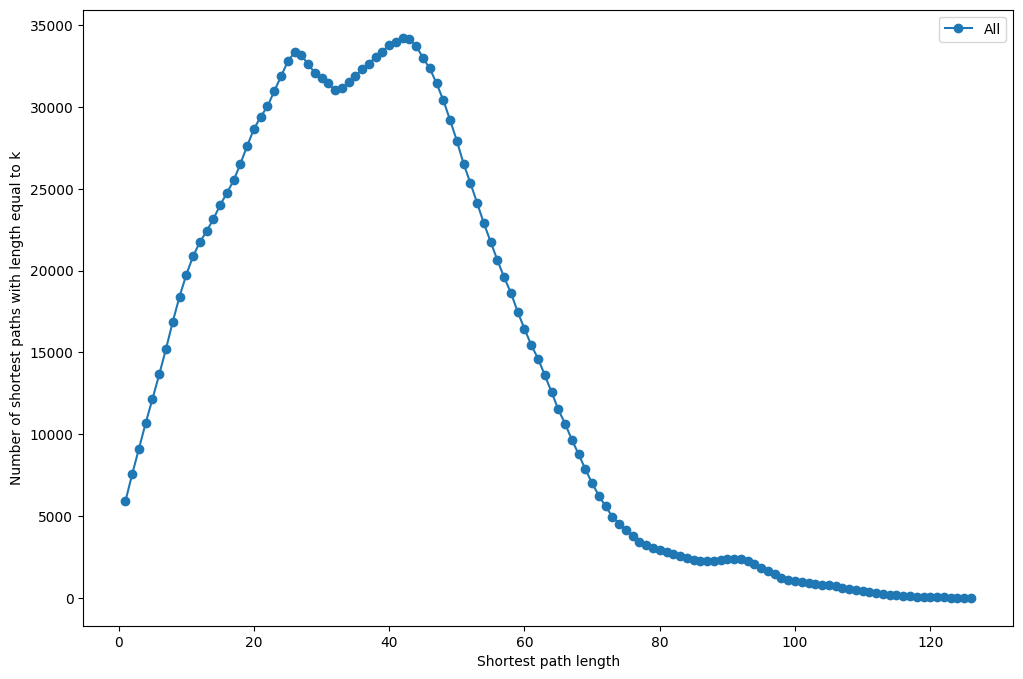

In [85]:
# Do the same for the entire graph
plt.figure(figsize=(12, 8))
shortest_path_lengths = nx.shortest_path_length(G_multi_directed)
shortest_path_lengths = [length for node, lengths in shortest_path_lengths for length in lengths.values()]
shortest_path_lengths = [length for length in shortest_path_lengths if length != 0]
shortest_path_lengths = sorted(shortest_path_lengths, reverse=True)
shortest_path_lengths_count = collections.Counter(shortest_path_lengths)
spl, cnt = zip(*shortest_path_lengths_count.items())
plt.plot(spl, cnt, 'o-', label='All')

plt.xlabel('Shortest path length')
plt.ylabel('Number of shortest paths with length equal to k')
plt.legend()

plt.savefig('latex_figures/shortest_path_length_distribution_all.png')
plt.show()

In [86]:
# Write a function that takes in a graph, and returns the number of nodes, edges, inflection points, and bridges in the graph
def get_bridges_and_articulation(graph, country_code=None):
    if country_code:
        graph = graph.subgraph([n for n in graph.nodes if graph.nodes[n]['country_code'] == country_code])
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    num_articulation_points = len(list(nx.articulation_points(graph)))
    num_bridges = len(list(nx.bridges(graph)))
    return num_nodes, num_edges, num_articulation_points, num_bridges

In [87]:
# Test the function on G_multi_directed
print(get_bridges_and_articulation(G_multi_undirected))

(4675, 6160, 1706, 2210)


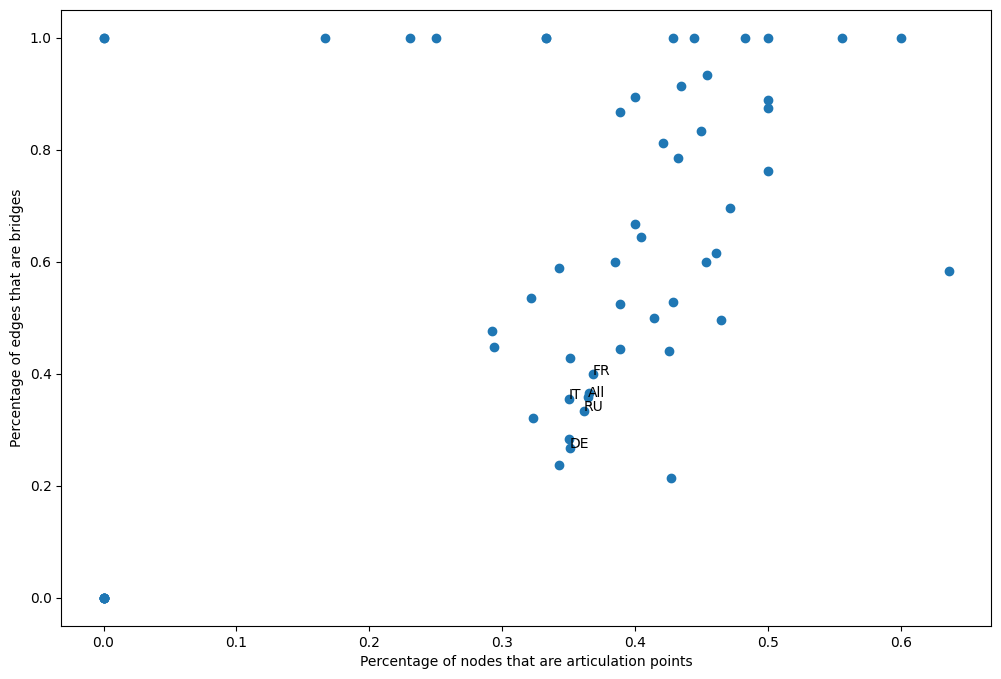

In [88]:
# Plot the percentage of nodes that are articulation points and bridges for all countries and the entire graph
articulation_share = []
bridges_share = []
for country_code in countries_list:
    num_nodes, num_edges, num_articulation_points, num_bridges = get_bridges_and_articulation(G_multi_undirected, country_code)
    try:
        articulation_share.append(num_articulation_points / num_nodes)
    except ZeroDivisionError:
        articulation_share.append(0)
    try:
        bridges_share.append(num_bridges / num_edges)
    except ZeroDivisionError:
        bridges_share.append(0)

articulation_share.append(len(list(nx.articulation_points(G_multi_undirected))) / G_multi_undirected.number_of_nodes())
bridges_share.append(len(list(nx.bridges(G_multi_undirected))) / G_multi_undirected.number_of_edges())

plt.figure(figsize=(12, 8))
plt.scatter(articulation_share, bridges_share)
plt.xlabel('Percentage of nodes that are articulation points')
plt.ylabel('Percentage of edges that are bridges')
# Give labels to DE, RU, FR, IT
for i, txt in enumerate(countries_list):
    if countries_df['number_of_nodes'][i] > 300:
        plt.annotate(txt, (articulation_share[i], bridges_share[i]))
# Give label to the country with both shares = 0
plt.annotate('All', (articulation_share[-1], bridges_share[-1]))

plt.savefig('latex_figures/percentage_of_nodes_that_are_articulation_points_vs_percentage_of_edges_that_are_bridges.png')
plt.show()

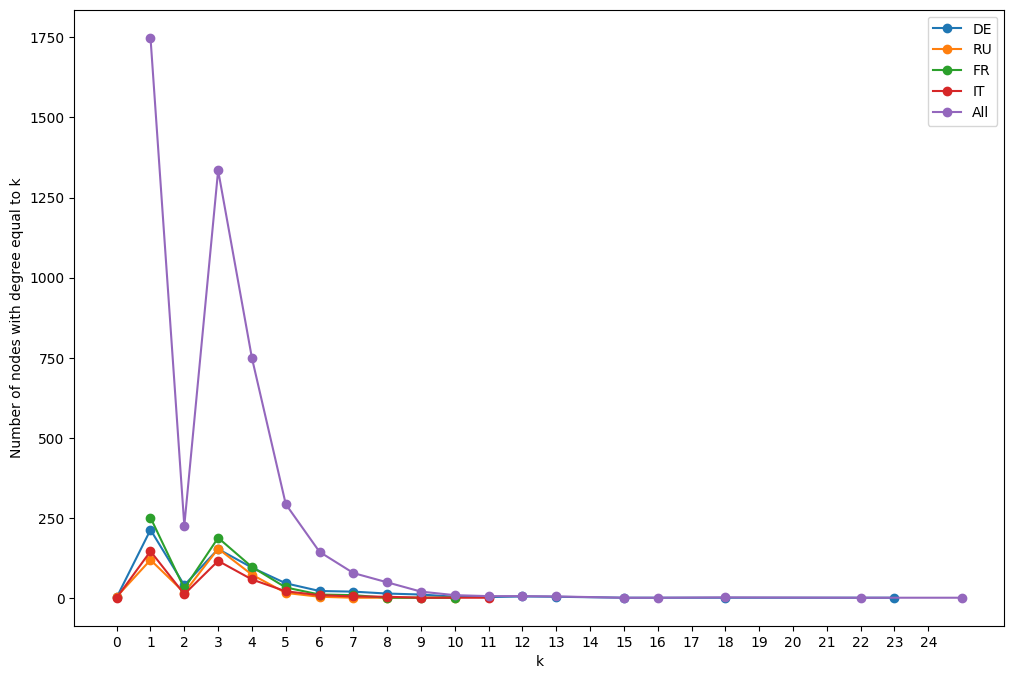

In [89]:
# Plot the degree distribution, non-cum, for the entire graph and the countries DE, RU, FR, IT
plt.figure(figsize=(12, 8))
for country_code in ['DE', 'RU', 'FR', 'IT']:
    # Create a subgraph of G_multi_directed where the country_code is the one we are interested in
    sub_graph = G_multi_directed.subgraph([n for n in G_multi_directed.nodes if G_multi_directed.nodes[n]['country_code'] == country_code])
    degree_sequence = sorted([d for n, d in sub_graph.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    plt.plot(deg, cnt, 'o-', label=country_code)

degree_sequence = sorted([d for n, d in G_multi_directed.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
plt.plot(deg, cnt, 'o-', label='All')

# Show all x-axis labels at 1 increments
plt.xticks(np.arange(0, 25, 1))
plt.xlabel('k')
plt.ylabel('Number of nodes with degree equal to k')
plt.legend()

plt.show()

In [90]:
# Print a value count for the flow_type attribute of the nodes in G_multi_directed
flow_type_count = G_multi_directed.nodes(data='flow_type')
flow_type_count = [flow_type for node, flow_type in flow_type_count]
flow_type_count = collections.Counter(flow_type_count)
print(flow_type_count)

Counter({'transit': 3758, 'sink': 672, 'source': 245})


In [91]:
# For the entire graph, and for nodes with degree < 10, plot, as stacked bar charts, the number of nodes per node type. The type of the node is an attribute of the node
node_types = set([G_multi_directed.nodes[node]['type'] for node in G_multi_directed.nodes])
node_type_dict = {"node": 0, "consumer": 0, "production": 0, "compressor": 0, "borderpoint": 0, "lng": 0, "storage": 0}

for node in G_multi_directed.nodes:
    node_type = G_multi_directed.nodes[node]['type']
    for key in node_type_dict:
        if key in node_type:
            node_type_dict[key] += 1

print(node_type_dict)


{'node': 4675, 'consumer': 447, 'production': 106, 'compressor': 239, 'borderpoint': 103, 'lng': 30, 'storage': 240}


{1: {'node': 1749, 'consumer': 347, 'production': 85, 'compressor': 31, 'borderpoint': 3, 'lng': 18, 'storage': 188}, 2: {'node': 226, 'consumer': 46, 'production': 8, 'compressor': 86, 'borderpoint': 43, 'lng': 7, 'storage': 22}, 3: {'node': 1335, 'consumer': 16, 'production': 5, 'compressor': 42, 'borderpoint': 10, 'lng': 3, 'storage': 9}, 4: {'node': 749, 'consumer': 22, 'production': 6, 'compressor': 28, 'borderpoint': 25, 'lng': 1, 'storage': 9}, 5: {'node': 293, 'consumer': 4, 'production': 2, 'compressor': 19, 'borderpoint': 4, 'lng': 1, 'storage': 4}, 6: {'node': 144, 'consumer': 3, 'production': 0, 'compressor': 12, 'borderpoint': 6, 'lng': 0, 'storage': 4}, 7: {'node': 78, 'consumer': 2, 'production': 0, 'compressor': 6, 'borderpoint': 1, 'lng': 0, 'storage': 0}, 8: {'node': 49, 'consumer': 1, 'production': 0, 'compressor': 9, 'borderpoint': 5, 'lng': 0, 'storage': 1}, 9: {'node': 20, 'consumer': 3, 'production': 0, 'compressor': 0, 'borderpoint': 0, 'lng': 0, 'storage': 1}, 

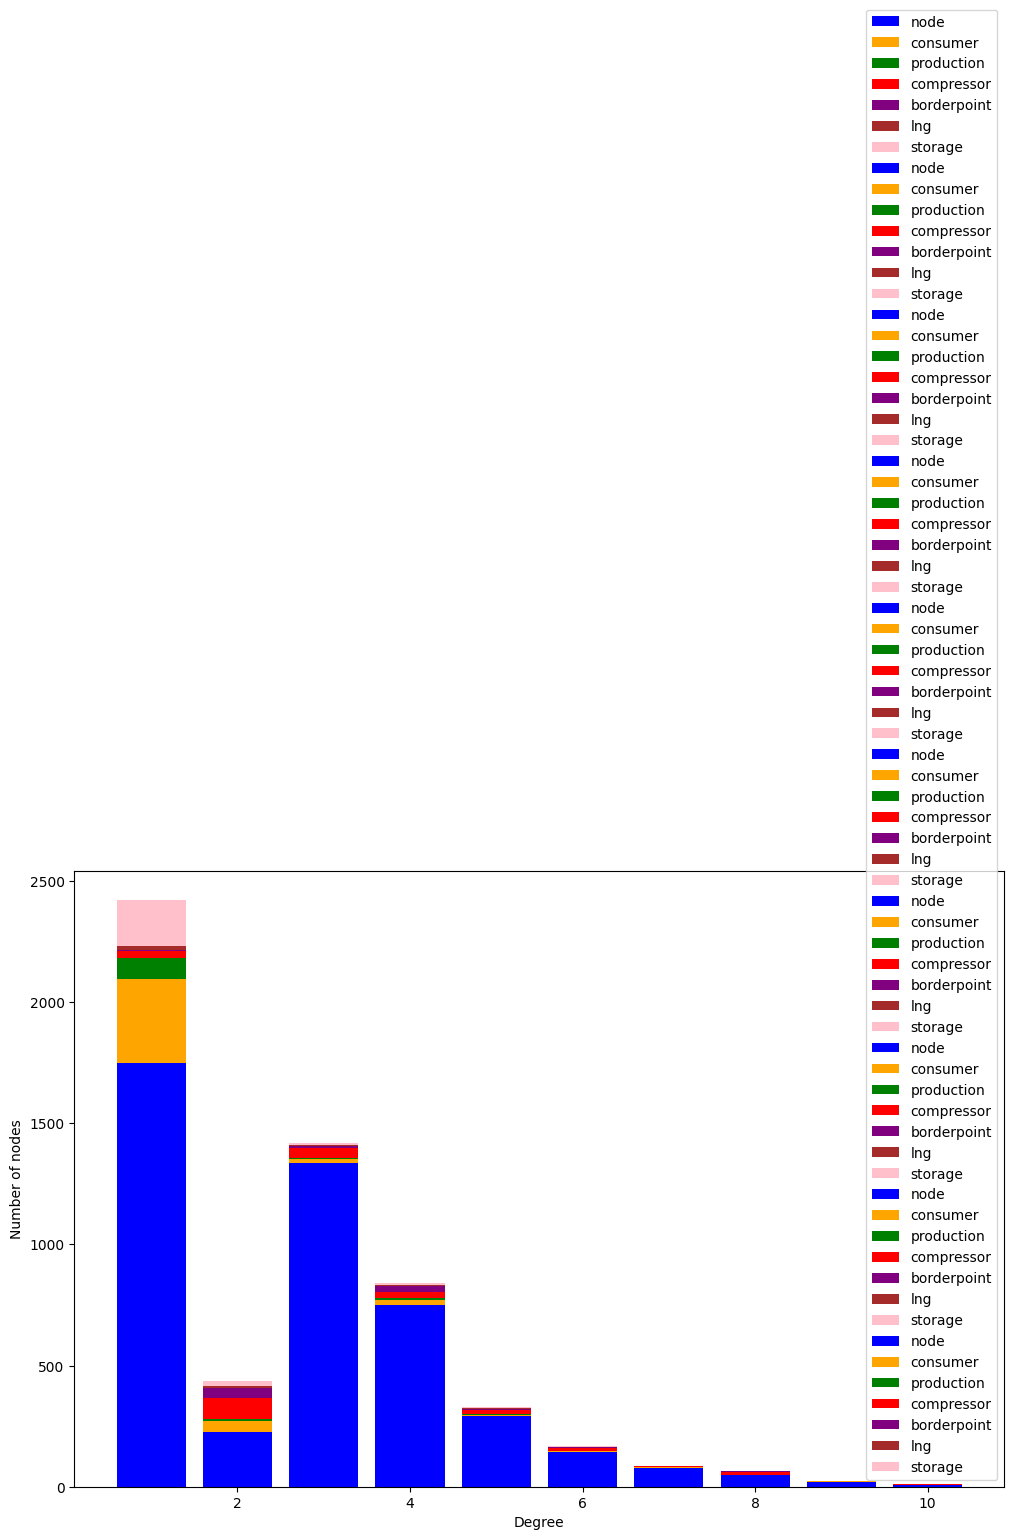

In [92]:
# For the entire graph, and for nodes with degree < 10, plot, as stacked bar charts, the number of nodes per node type. The type of the node is an attribute of the node

node_types = ['node', 'consumer', 'production', 'compressor', 'borderpoint', 'lng', 'storage']

# Create a dictionary where the keys are the degrees 1-10 and the values are dictionaries where the keys are the node_types and the values are the number of nodes of that type
degree_dict = {}
for degree in range(1, 11):
    degree_dict[degree] = {}
    for node_type in node_types:
        degree_dict[degree][node_type] = 0

for node in G_multi_directed.nodes:
    degree = G_multi_directed.degree[node]
    if degree > 10:
        continue
    for node_type in node_types:
        if node_type in G_multi_directed.nodes[node]['type']:
            degree_dict[degree][node_type] += 1

print(degree_dict)

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))
for degree in range(1, 11):
    bottom = 0
    for node_type in node_types:
        # Make the node_types that have the same name, have the same color across the different degrees
        if node_type == 'node':
            color = 'blue'
        elif node_type == 'consumer':
            color = 'orange'
        elif node_type == 'production':
            color = 'green'
        elif node_type == 'compressor':
            color = 'red'
        elif node_type == 'borderpoint':
            color = 'purple'
        elif node_type == 'lng':
            color = 'brown'
        elif node_type == 'storage':
            color = 'pink'
        ax.bar(degree, degree_dict[degree][node_type], bottom=bottom, label=node_type, color=color)
        bottom += degree_dict[degree][node_type]

# Have only one set of legends

plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.legend()
plt.show()

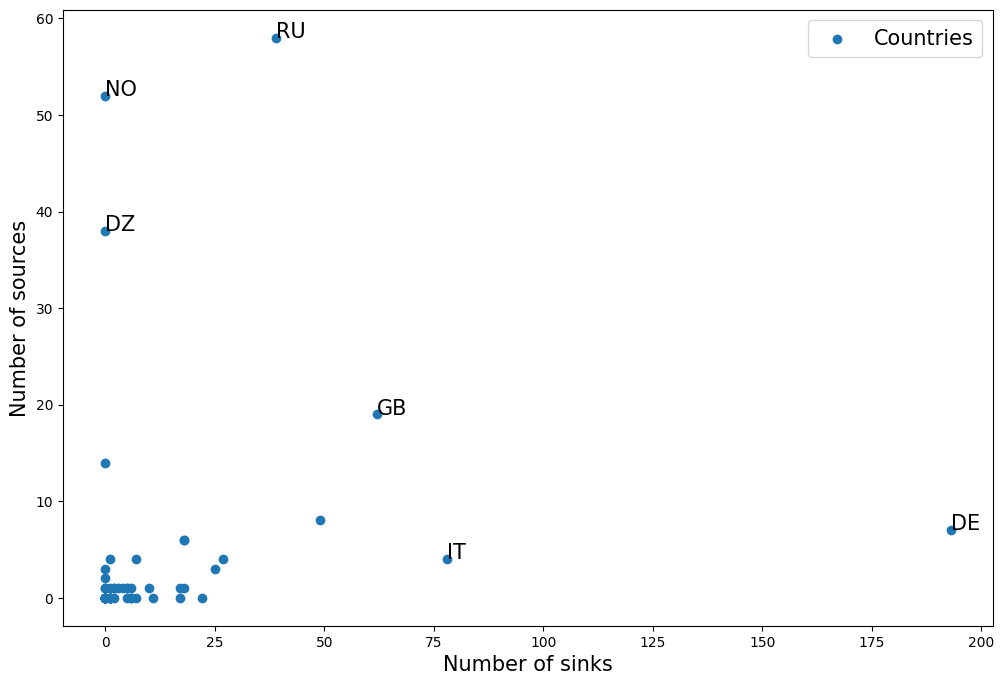

In [93]:
# For each country, plot the number of sinks in the country vs the number of sources in the country
sinks_sources_dict = {}
for node in G_multi_directed.nodes:
    country_code = G_multi_directed.nodes[node]['country_code']
    if country_code in sinks_sources_dict:
        if 'sink' in G_multi_directed.nodes[node]['flow_type']:
            sinks_sources_dict[country_code][0] += 1
        if 'source' in G_multi_directed.nodes[node]['flow_type']:
            sinks_sources_dict[country_code][1] += 1
    else:
        sinks_sources_dict[country_code] = [0, 0]
        if 'sink' in G_multi_directed.nodes[node]['flow_type']:
            sinks_sources_dict[country_code][0] += 1
        if 'source' in G_multi_directed.nodes[node]['flow_type']:
            sinks_sources_dict[country_code][1] += 1

sinks_sources_df = pd.DataFrame.from_dict(sinks_sources_dict, orient='index', columns=['number_of_sinks', 'number_of_sources'])

plt.figure(figsize=(12, 8))
plt.scatter(sinks_sources_df['number_of_sinks'], sinks_sources_df['number_of_sources'])
plt.xlabel('Number of sinks', fontsize=15)
plt.ylabel('Number of sources', fontsize=15)
for i, txt in enumerate(sinks_sources_df.index):
    if sinks_sources_df['number_of_sinks'][i] > 50 or sinks_sources_df['number_of_sources'][i] > 30:
        plt.annotate(txt, (sinks_sources_df['number_of_sinks'][i], sinks_sources_df['number_of_sources'][i]), fontsize=15)

plt.legend(['Countries', 'Complete network'], fontsize=15)
plt.savefig('latex_figures/number_of_sinks_vs_number_of_sources.png')
plt.show()

In [94]:
# Print the number of unique values in the country_code attribute of the nodes in G_multi_directed
print("Number of unique values in G_multi_directed:")
print(len(pd.Series(nx.get_node_attributes(G_multi_directed, 'country_code')).value_counts()))

Number of unique values in G_multi_directed:
55
